In [1]:
#import libraries
import xgboost as xg
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, KFold, GridSearchCV, cross_val_predict
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, LeakyReLU
from sklearn.metrics import r2_score
import data_ML as ML
import pickle
from keras.models import load_model
from tqdm import tqdm
from sklearn.pipeline import Pipeline



np.set_printoptions(suppress=True)

In [2]:
df = ML.getdata(True)

def modifydata(df):
    data_calls = []
    data_puts = []
    df_puts = df[df.optionType == 0].drop(columns='optionType')
    df_calls = df[df.optionType == 1].drop(columns='optionType')
    df_eu_calls = df_calls[df_calls.method == 0].drop(columns='method')
    df_eu_puts = df_puts[df_puts.method == 0].drop(columns='method')
    df_eu_calls = df_eu_calls[df_eu_calls.lastPrice > 10]
    df_eu_puts = df_eu_puts[df_eu_puts.lastPrice > 10]
    y_calls = np.asarray(df_eu_calls[['lastPrice']])
    y_puts = np.asarray(df_eu_puts[['lastPrice']])
    df_eu_calls = df_eu_calls.drop(columns='lastPrice')
    df_eu_puts = df_eu_puts.drop(columns='lastPrice')

    for line in range(len(df_eu_calls)):
        data_tmp = df_eu_calls.iloc[line]
        data_calls.append(data_tmp)
    data_calls = np.asarray(data_calls)


    for line in range(len(df_eu_puts)):
        data_tmp = df_eu_puts.iloc[line]
        data_puts.append(data_tmp)
    data_puts = np.asarray(data_puts)

    return data_calls, data_puts, y_calls, y_puts

In [23]:
import seaborn as sns
palette = sns.color_palette('tab20',20)


def model(pipeline, parameters, X_train, y_train, X, y, figname):
    grid_obj = GridSearchCV(estimator = pipeline, param_grid = parameters, cv = 5, scoring = 'r2', verbose = 0, n_jobs = 1, refit = True)
    grid_obj.fit(X_train, y_train)

    print("Best Param:", grid_obj.best_params_)
    estimator = grid_obj.best_estimator_
    shuffle = KFold(n_splits = 5, shuffle = True, random_state = 0)
    cv_scores = cross_val_score(estimator, X, y.ravel(), cv=shuffle, scoring='r2')

    y_pred = cross_val_predict(estimator, X, y, cv = shuffle)
    plt.figure(figsize = (5,4))
    plt.scatter(y, y_pred, color = palette[0], s=10)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], color = palette[1], lw = 2, alpha = 0.4)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title('CV R-squared: {:.4f}\n'.format(float(cv_scores.mean())), size = 12)
    plt.savefig('./Presentation files/CV_XGBr_puts_plot.png')
    plt.show()
    

In [4]:
X_calls, X_puts, y_calls, y_puts = modifydata(df)
X_train_calls, X_test_calls, y_train_calls, y_test_calls = train_test_split(X_calls, y_calls, test_size=0.25)
X_train_puts, X_test_puts, y_train_puts, y_test_puts = train_test_split(X_puts, y_puts, test_size=0.25)

In [5]:
X_train_calls.shape

(5134, 5)

In [24]:
# XGBr Regressor for calls
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pipe_xgb = Pipeline([('xgb', xg.XGBRegressor())])
param_xgb = {'xgb__max_depth':[3,4,5,6], 'xgb__min_child_weight':[4,5,6], 'xgb__gamma': [0.001, 0.01, 0.1], 'xgb__subsample':[0.6,0.7,0.8], 'xgb__colsample_bytree':[1]}
model(pipe_xgb, param_xgb, X_train_calls, y_train_calls, X_test_calls, y_test_calls, 'xgboost')

KeyboardInterrupt: 

Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__min_child_weight': 5, 'xgb__subsample': 0.8}


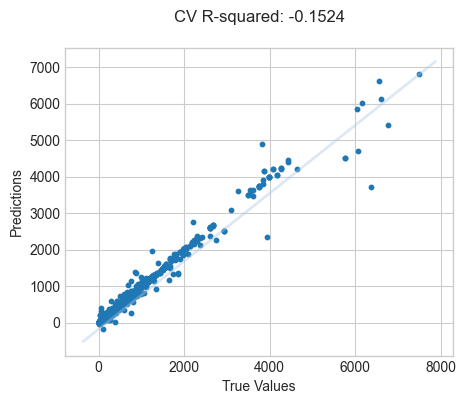

In [17]:
# XGBr Regressor for puts
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pipe_xgb = Pipeline([('xgb', xg.XGBRegressor())])
param_xgb = {'xgb__max_depth':[3,4,5], 'xgb__min_child_weight':[4,5,6], 'xgb__gamma': [0.001, 0.01, 0.1], 'xgb__subsample':[0.6,0.7,0.8], 'xgb__colsample_bytree':[1]}
model(pipe_xgb, param_xgb, X_train_puts, y_train_puts, X_test_puts, y_test_puts, 'xgboost')

In [20]:
XGBr_eu_calls = xg.XGBRegressor(learning_rate=0.15, colsample_bytree= 1, gamma= 0.001, max_depth= 5, min_child_weight= 4, subsample= 1, n_estimators=900)
XGBr_eu_calls.fit(X_train_calls, y_train_calls)
XGBr_pred = XGBr_eu_calls.predict(X_test_calls)
XGBr_rmse = np.sqrt(mean_squared_error(y_test_calls, XGBr_pred))
XGBr_rmse
# Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__min_child_weight': 4, 'xgb__subsample': 0.8}

32.6943704431815

In [21]:
XGBr_eu_puts = xg.XGBRegressor(learning_rate=0.1, colsample_bytree= 1, gamma= 0.001, max_depth= 5, min_child_weight= 6, subsample= 1, n_estimators=900)
XGBr_eu_puts.fit(X_train_puts, y_train_puts)
XGBr_pred = XGBr_eu_puts.predict(X_test_puts)
XGBr_rmse = np.sqrt(mean_squared_error(y_test_puts, XGBr_pred))
XGBr_rmse
# Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__min_child_weight': 6, 'xgb__subsample': 0.7}


20.892662461119315

In [22]:
# Save the trained model to a file
filename = 'XGBr_eu_puts.sav'
pickle.dump(XGBr_eu_puts, open(filename, 'wb'))
filename = 'XGBr_eu_calls.sav'
pickle.dump(XGBr_eu_calls, open(filename, 'wb'))